In [7]:
import numpy as np
import matplotlib.pyplot as plt
import time

# --- 1. Define Objective Functions and Gradients ---

def rosenbrock(params):
    x, y = params[0], params[1]
    return (1 - x)**2 + 100 * (y - x**2)**2

def rosenbrock_grad(params):
    x, y = params[0], params[1]
    # df/dx = -2(1-x) - 400x(y - x^2)
    dx = -2 * (1 - x) - 400 * x * (y - x**2)
    # df/dy = 200(y - x^2)
    dy = 200 * (y - x**2)
    return np.array([dx, dy])

def sin_inv(params):
    x = params[0]
    # Handle x = 0 by returning 0
    if np.isclose(x, 0, atol=1e-8):
        return 0.0
    return np.sin(1 / x)

def sin_inv_grad(params):
    x = params[0]
    # Handle x = 0 or very small x to prevent overflow/division by zero
    if np.isclose(x, 0, atol=1e-8):
        return np.array([0.0])

    # f'(x) = -cos(1/x) / x^2
    grad = -np.cos(1 / x) / (x**2)

    # Clip gradient to prevent explosion near 0 for stability
    grad = np.clip(grad, -1e5, 1e5)
    return np.array([grad])

In [8]:
# --- 2. Optimizer Implementations (From Scratch) ---

class Optimizer:
    def __init__(self, lr=0.01):
        self.lr = lr

    def step(self, params, grads):
        raise NotImplementedError

class GradientDescent(Optimizer):
    def step(self, params, grads):
        return params - self.lr * grads

class SGD_Momentum(Optimizer):
    def __init__(self, lr=0.01, momentum=0.9):
        super().__init__(lr)
        self.momentum = momentum
        self.velocity = None

    def step(self, params, grads):
        if self.velocity is None:
            self.velocity = np.zeros_like(params)

        self.velocity = self.momentum * self.velocity + self.lr * grads
        return params - self.velocity

class Adagrad(Optimizer):
    def __init__(self, lr=0.01, epsilon=1e-8):
        super().__init__(lr)
        self.epsilon = epsilon
        self.cache = None

    def step(self, params, grads):
        if self.cache is None:
            self.cache = np.zeros_like(params)

        self.cache += grads**2
        update = (self.lr / (np.sqrt(self.cache) + self.epsilon)) * grads
        return params - update

class RMSprop(Optimizer):
    def __init__(self, lr=0.01, decay_rate=0.9, epsilon=1e-8):
        super().__init__(lr)
        self.decay_rate = decay_rate
        self.epsilon = epsilon
        self.cache = None

    def step(self, params, grads):
        if self.cache is None:
            self.cache = np.zeros_like(params)

        self.cache = self.decay_rate * self.cache + (1 - self.decay_rate) * (grads**2)
        update = (self.lr / (np.sqrt(self.cache) + self.epsilon)) * grads
        return params - update

class Adam(Optimizer):
    def __init__(self, lr=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8):
        super().__init__(lr)
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = None
        self.v = None
        self.t = 0

    def step(self, params, grads):
        if self.m is None:
            self.m = np.zeros_like(params)
            self.v = np.zeros_like(params)

        self.t += 1

        # Update moments
        self.m = self.beta1 * self.m + (1 - self.beta1) * grads
        self.v = self.beta2 * self.v + (1 - self.beta2) * (grads**2)

        # Bias correction
        m_hat = self.m / (1 - self.beta1**self.t)
        v_hat = self.v / (1 - self.beta2**self.t)

        update = (self.lr / (np.sqrt(v_hat) + self.epsilon)) * m_hat
        return params - update

In [9]:
# --- 3. Training Loop Helper ---

def run_optimization(optimizer_class, func, func_grad, start_params, lr, iterations=1000, threshold=1e-6, **kwargs):
    """
    Runs optimization for a specific setting.
    """
    params = np.array(start_params, dtype=float)
    optimizer = optimizer_class(lr=lr, **kwargs)

    history_loss = []
    history_params = [params.copy()]

    start_time = time.time()

    for i in range(iterations):
        loss = func(params)
        grads = func_grad(params)

        history_loss.append(loss)

        # Stopping criteria: Gradient norm small enough
        if np.linalg.norm(grads) < threshold:
            break

        # Stopping criteria: Loss divergence
        if loss > 1e10 or np.isnan(loss):
            print(f"Diverged at iteration {i}")
            break

        params = optimizer.step(params, grads)
        history_params.append(params.copy())

    end_time = time.time()
    time_taken = end_time - start_time

    return {
        'final_params': params,
        'final_loss': func(params),
        'history_loss': history_loss,
        'history_params': np.array(history_params),
        'time': time_taken,
        'iterations': i + 1
    }

In [10]:
# --- 4. Running Experiments: Rosenbrock ---

learning_rates = [0.01, 0.05, 0.1]
optimizers_map = {
    "GD": GradientDescent,
    "Momentum": SGD_Momentum,
    "Adagrad": Adagrad,
    "RMSprop": RMSprop,
    "Adam": Adam
}

# Starting point (Standard start point to test ability to reach 1,1)
start_rosen = [-1.0, 2.0]
results_rosen = {}

print("--- Optimization on Rosenbrock Function ---")
print(f"Target Global Minimum: x=1.0000, y=1.0000\n")

for lr in learning_rates:
    results_rosen[lr] = {}
    print(f"--- Learning Rate: {lr} ---")
    print(f"{'Optimizer':<10} | {'Final Loss':<12} | {'Final X':<10} | {'Final Y':<10} | {'Time (s)':<8}")
    print("-" * 65)

    for name, opt_class in optimizers_map.items():
        res = run_optimization(
            opt_class, rosenbrock, rosenbrock_grad,
            start_rosen, lr, iterations=3000
        )
        results_rosen[lr][name] = res

        # Extract x and y
        final_x = res['final_params'][0]
        final_y = res['final_params'][1]

        print(f"{name:<10} | {res['final_loss']:<12.5f} | {final_x:<10.4f} | {final_y:<10.4f} | {res['time']:<8.4f}")
    print("\n")

--- Optimization on Rosenbrock Function ---
Target Global Minimum: x=1.0000, y=1.0000

--- Learning Rate: 0.01 ---
Optimizer  | Final Loss   | Final X    | Final Y    | Time (s)
-----------------------------------------------------------------
Diverged at iteration 2
GD         | 5451577882396.86426 | 483.2549   | 49.2032    | 0.0002  
Diverged at iteration 2
Momentum   | 5292576476286.95703 | 479.6909   | 47.4032    | 0.0001  
Adagrad    | 5.28290      | -1.2975    | 1.6901     | 0.1920  
RMSprop    | 0.02262      | 0.9676     | 0.9510     | 0.0903  
Adam       | 0.18081      | 0.5750     | 0.3292     | 0.1224  


--- Learning Rate: 0.05 ---
Optimizer  | Final Loss   | Final X    | Final Y    | Time (s)
-----------------------------------------------------------------
Diverged at iteration 2
GD         | 112858016694324286193664.00000 | 183287.6200 | 4398.4000  | 0.0001  
Diverged at iteration 2
Momentum   | 112814133008703162417152.00000 | 183269.8000 | 4389.4000  | 0.0001  
Adagrad 

In [11]:
# --- 5. Running Experiments: Sin(1/x) ---

start_sin = [0.5] # Start slightly away from 0
results_sin = {}

print("\n--- Optimization on Sin(1/x) Function ---")
for lr in learning_rates:
    results_sin[lr] = {}
    print(f"\nLearning Rate: {lr}")
    for name, opt_class in optimizers_map.items():
        res = run_optimization(
            opt_class, sin_inv, sin_inv_grad,
            start_sin, lr, iterations=2000
        )
        results_sin[lr][name] = res
        print(f"{name:>10} | Loss: {res['final_loss']:.5f} | x: {res['final_params'][0]:.4f}")


--- Optimization on Sin(1/x) Function ---

Learning Rate: 0.01
        GD | Loss: 0.97741 | x: 0.5606
  Momentum | Loss: 0.02953 | x: 33.8595
   Adagrad | Loss: -1.00000 | x: 0.2122
   RMSprop | Loss: -1.00000 | x: 0.2122
      Adam | Loss: -1.00000 | x: 0.2122

Learning Rate: 0.05
        GD | Loss: 0.15034 | x: 6.6266
  Momentum | Loss: 0.05995 | x: 16.6712
   Adagrad | Loss: -1.00000 | x: 0.2122
   RMSprop | Loss: -0.89825 | x: 0.1935
      Adam | Loss: -1.00000 | x: 0.2122

Learning Rate: 0.1
        GD | Loss: -1.00000 | x: -0.6366
  Momentum | Loss: -1.00000 | x: -0.6366
   Adagrad | Loss: -1.00000 | x: 0.2122
   RMSprop | Loss: -1.00000 | x: 0.2122
      Adam | Loss: -1.00000 | x: 0.2122


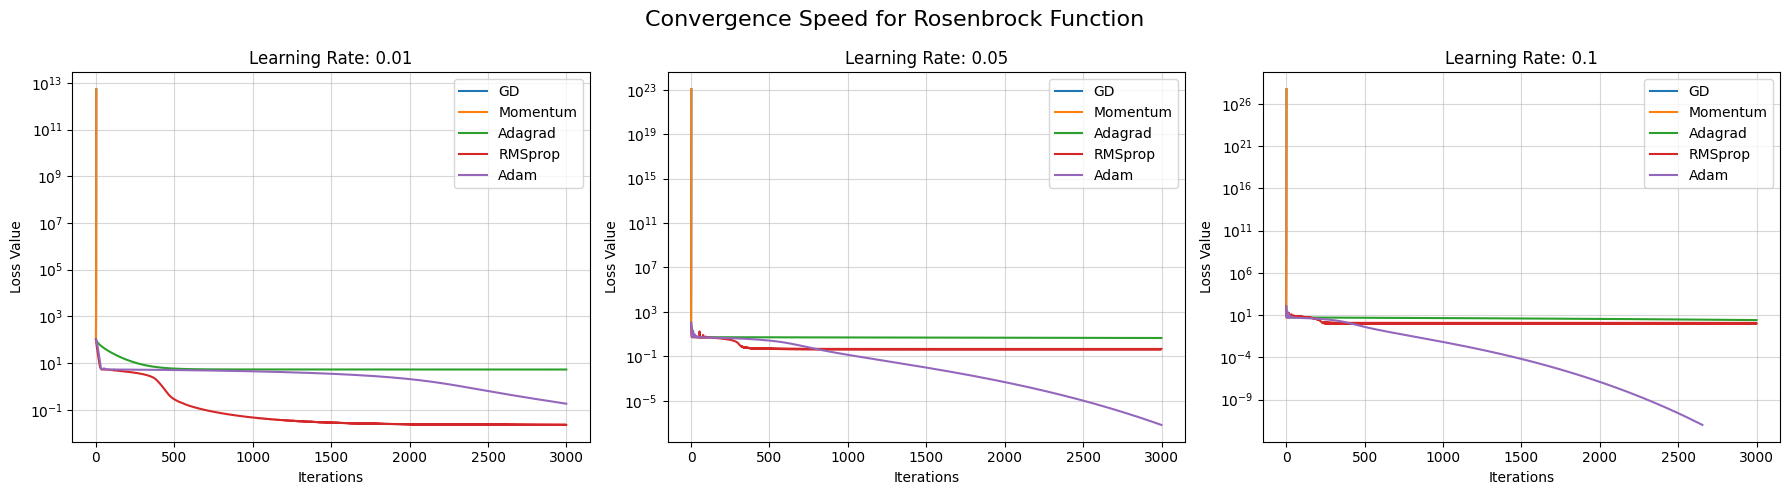

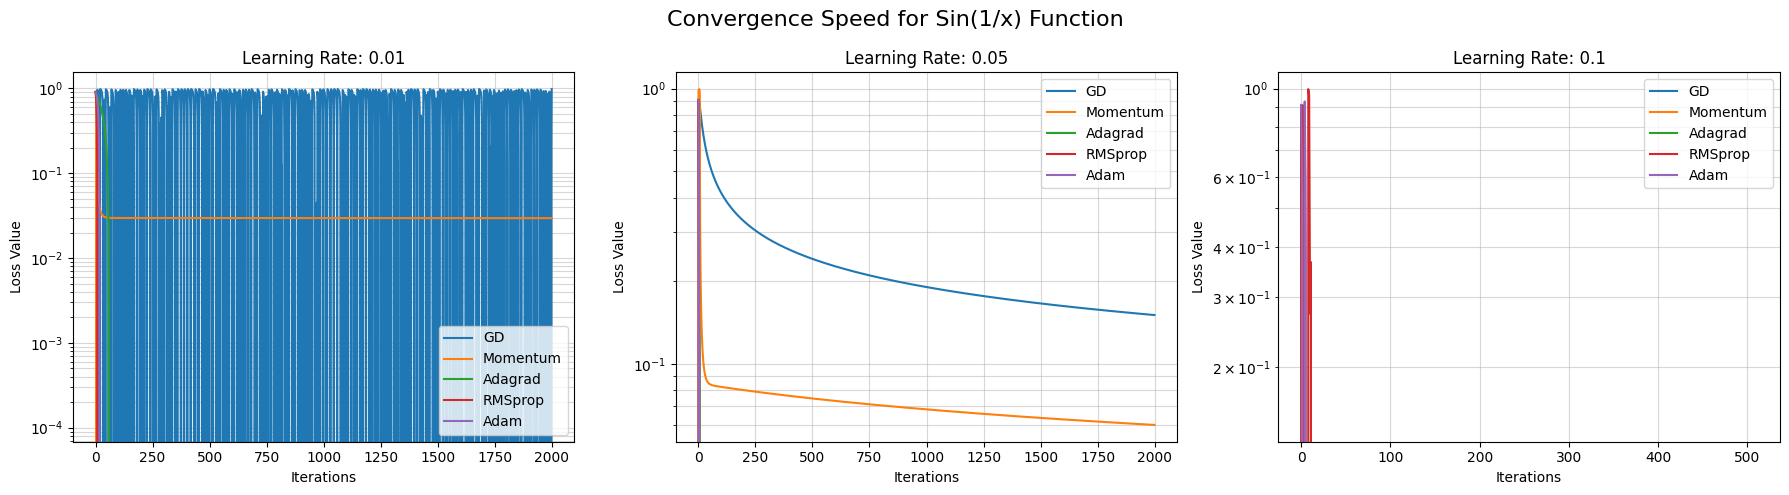

In [12]:
# --- 6. Visualization & Plotting ---

def plot_convergence(results_dict, func_name):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f'Convergence Speed for {func_name}', fontsize=16)

    for idx, lr in enumerate(learning_rates):
        ax = axes[idx]
        for name, res in results_dict[lr].items():
            ax.plot(res['history_loss'], label=name)

        ax.set_title(f'Learning Rate: {lr}')
        ax.set_xlabel('Iterations')
        ax.set_ylabel('Loss Value')
        ax.set_yscale('log') # Log scale helps see convergence better
        ax.legend()
        ax.grid(True, which="both", ls="-", alpha=0.5)

    plt.tight_layout()
    plt.show()

# Plot Rosenbrock Results
plot_convergence(results_rosen, "Rosenbrock Function")

# Plot Sin(1/x) Results
plot_convergence(results_sin, "Sin(1/x) Function")
